# Experiments

In [67]:
from time import time
import numpy as np
import xarray as xr

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor

import matplotlib.pyplot as plt

## Load data

In [2]:
data = xr.open_dataset("../data/delhi_cpcb_2022.nc")
data

<xarray.Dataset>
Dimensions:    (station: 40, time: 8783)
Coordinates:
  * station    (station) object 'Alipur, Delhi - DPCC' ... 'Wazirpur, Delhi -...
  * time       (time) datetime64[ns] 2022-01-01T00:30:00 ... 2023-01-01T22:23:30
    latitude   (station) float64 ...
    longitude  (station) float64 ...
Data variables: (12/21)
    From Date  (station, time) datetime64[ns] ...
    To Date    (station, time) datetime64[ns] ...
    PM2.5      (station, time) float64 ...
    PM10       (station, time) float64 ...
    NO         (station, time) float64 ...
    NO2        (station, time) float64 ...
    ...         ...
    WD         (station, time) float64 ...
    SR         (station, time) float64 ...
    BP         (station, time) float64 ...
    AT         (station, time) float64 ...
    RF         (station, time) float64 ...
    TOT-RF     (station, time) float64 ...

In [3]:
df = data.to_dataframe().reset_index().set_index("time")
df = df["2022-01-01": "2022-12-31"]

df["datetime"] = df.index
df["time"] = df.index.astype(np.int64) / 10 ** 18

/tmp/ipykernel_2981117/3348861195.py:2: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df = df["2022-01-01": "2022-12-31"]


## Split data

In [4]:
all_stations = df.station.unique()
train_station, test_station = train_test_split(all_stations, test_size=0.2, random_state=42)
train_df = df[df.station.isin(train_station)].dropna(subset=["PM2.5"])
test_df = df[df.station.isin(test_station)].dropna(subset=["PM2.5"]) 

train_df.shape, test_df.shape

((248033, 26), (68279, 26))

## Run experiments

### Random Forest

In [5]:
init = time()
model = RandomForestRegressor(n_estimators=1000, random_state=42, n_jobs=-1)
model.fit(train_df[["latitude", "longitude", "time"]], train_df["PM2.5"])
pred_y = model.predict(test_df[["latitude", "longitude", "time"]])

rmse = mean_squared_error(test_df["PM2.5"].values.ravel(), pred_y.ravel(), squared=False)

print(f"RMSE: {rmse:.2f}")
print(f"Finished in {(time() - init)/60:.2f} minutes")

RMSE: 43.32
Finished in 0.21 minutes


### Constant mean prediction

In [6]:
pred_y = np.ones(test_df.shape[0]) * train_df["PM2.5"].mean()

rmse = mean_squared_error(test_df["PM2.5"].values.ravel(), pred_y.ravel(), squared=False)

print(f"RMSE: {rmse:.2f}")

RMSE: 83.06


### Mean prediction per time-step

In [7]:
mean_predictions = train_df.groupby("datetime").agg({"PM2.5": "mean"})

test_df["pred_y"] = mean_predictions["PM2.5"]

rmse = mean_squared_error(test_df["PM2.5"].values.ravel(), test_df["pred_y"].values.ravel(), squared=False)

print(f"RMSE: {rmse:.2f}")

RMSE: 35.54


#### RMSE for each time-step

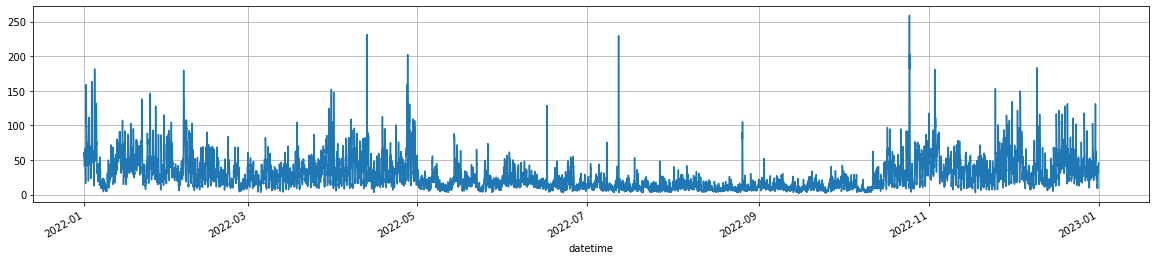

In [20]:
rmse_df = test_df.groupby("datetime").agg({"pred_y": list, "PM2.5": list}).apply(lambda x: mean_squared_error(x["PM2.5"], x["pred_y"], squared=False), axis=1)
rmse_df.plot(figsize=(20,4), grid=True);

### Decision Tree per time-step

Training finished in 5.30 seconds


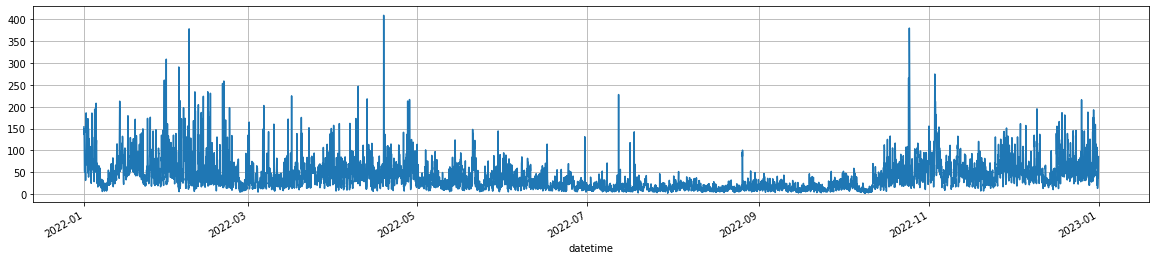

In [78]:
def get_X_y(x):
    x = x.apply(np.array)
    X = np.hstack([x["latitude"][:, None], x["longitude"][:, None], x["time"][:, None]])
    y = np.array(x["PM2.5"])
    return X, y

## Train a model for each time step
init = time()
def fit_model(x):
    X, y = get_X_y(x)
    model = DecisionTreeRegressor(random_state=42, max_depth=10)
    model.fit(X, y)
    return model

train_time_df = train_df.groupby("datetime").agg({"latitude": list, "longitude": list, "time": list, "PM2.5": list})
train_time_df["model"] = train_time_df.apply(fit_model, axis=1)
print(f"Training finished in {time() - init:.2f} seconds")

## Predict for each time step
def predict_model(x):
    X, y = get_X_y(x)
    model = x["model"]
    return model.predict(X)

test_time_df = test_df.groupby("datetime").agg({"latitude": list, "longitude": list, "time": list, "PM2.5": list})
test_time_df["model"] = train_time_df["model"]
test_time_df["pred_y"] = test_time_df.apply(predict_model, axis=1)

## Compute RMSE for each time step
test_time_df["RMSE"] = test_time_df.apply(lambda x: mean_squared_error(x["PM2.5"], x["pred_y"], squared=False), axis=1)
test_time_df["RMSE"].plot(figsize=(20,4), grid=True);

### How much better is the decision tree per time-step compared to mean prediction per time-step?

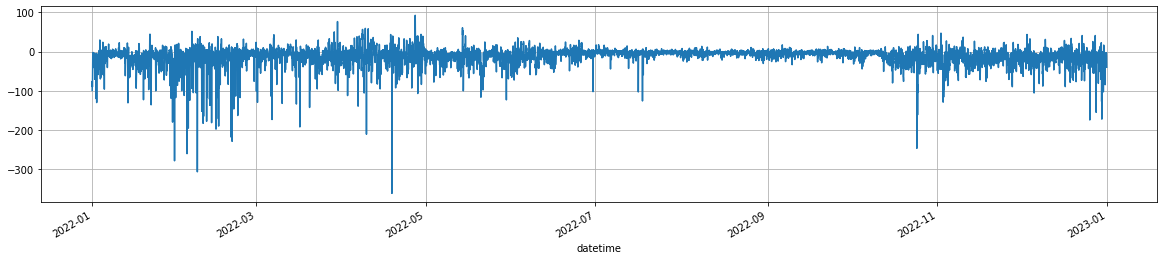

In [84]:
test_time_df["MeanModel RMSE"] = rmse_df
test_time_df["Diff"] = test_time_df["MeanModel RMSE"] - test_time_df["RMSE"]

test_time_df["Diff"].plot(figsize=(20,4), grid=True);

Decision tree per time-step is worst than mean prediction per time-steps for many time-steps.

#### Fraction of time steps where decision tree per time-step is better than mean prediction per time-step

In [89]:
test_time_df["Diff"].apply(np.sign).value_counts()/test_time_df.shape[0]

-1.0    0.798516
 1.0    0.201484
Name: Diff, dtype: float64

Only 20% of the time-steps